In [20]:
import pandas as pd
import numpy as np

shark_df = pd.read_excel('./shark-dataset.xls')
# create dataframe copy
original_df = shark_df.copy()
shark_df

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2024-10-14 00:00:00,2024.0,Unprovoked,Honduras,Tela,Atlantida,Swimming,Roberto Carlose Bu Mejia,M,38,...,Bull shark,Georgienne Bradley: Daily Mail UK: FTN News.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-11 00:00:00,2024.0,Unprovoked,USA,Florida,Brevard County Orlando,Surfing,Teddy Witteman,M,16,...,Bull shark 6ft,Todd SmithFlorida today: News 4:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-09-17 00:00:00,2024.0,Unprovoked,Honduras,Trujillo Colon,Puerto Castillo,Diving for shellfish,Fernando Mendoza Ocampo,M,33,...,Bull shark 6-7ft,Daily Mail UK: The Sun UK: The World Watch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-09-16 00:00:00,2024.0,Unprovoked,Morocco,Southern Morocco,West of Dakhla,Swimming - jumped off yacht,German Tourist,F,30,...,Reportedly a Great White,Andy Currie: Moroccan World News: Sky News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-08-26 00:00:00,2024.0,Unprovoked,Jamaica,Montego Bay,Falmouth,Spearfishing,Jahmari Reid,M,16,...,Reportedly Tiger Shark,Todd Smith: Daily Mail UK: Sky News: People .com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6968,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,Roebuck Bay,Diving,male,M,NaN,...,NaN,"H. Taunton; N. Bartlett, p. 234",ND-0005-RoebuckBay.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0005,ND.0005,6.0,NaN,NaN
6969,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,NaN,Pearl diving,Ahmun,M,NaN,...,NaN,"H. Taunton; N. Bartlett, pp. 233-234",ND-0004-Ahmun.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0004,ND.0004,5.0,NaN,NaN
6970,1900-1905,0.0,Unprovoked,USA,North Carolina,Ocracoke Inlet,Swimming,Coast Guard personnel,M,NaN,...,NaN,"F. Schwartz, p.23; C. Creswell, GSAF",ND-0003-Ocracoke_1900-1905.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0003,ND.0003,4.0,NaN,NaN
6971,1883-1889,0.0,Unprovoked,PANAMA,NaN,"Panama Bay 8ºN, 79ºW",NaN,Jules Patterson,M,NaN,...,NaN,"The Sun, 10/20/1938",ND-0002-JulesPatterson.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0002,ND.0002,3.0,NaN,NaN


Data cleaning to-do's:
- (done) column names to lowercase
- (done) column names - remove empty space after name
- (done) column names - replace empty spaces with underscores
- find unique values in columns
- find duplicate rows
- year names without floating
- column 'Unnamed: 21' & 'Unnamed: 22' - what do we do with them?

In [22]:
# column names to lowercase, remove empty space in the end, replace empty spaces with underscore
shark_df.columns = shark_df.columns.str.lower().str.strip().str.replace(" ", "_")

# remove multiple columns:
shark_df = shark_df.drop(['type', 'state', 'name', 'species', 'source', 'pdf', 'href_formula', 'href', 'case_number', 'case_number.1', 'original_order', 'unnamed:_21', 'unnamed:_22', 'time'], axis=1)

# convert year values to int
# shark_df['year'] = shark_df['year'].apply(lambda x: int(x) if isinstance(x, float) else x)
shark_df

,date,year,country,location,activity,sex,age,injury,unnamed:_11
0,2024-10-14 00:00:00,2024.0,Honduras,Atlantida,Swimming,M,38,Back and thigh extensive tissue loss,N
1,2024-10-11 00:00:00,2024.0,USA,Brevard County Orlando,Surfing,M,16,Bite to left arm,N
2,2024-09-17 00:00:00,2024.0,Honduras,Puerto Castillo,Diving for shellfish,M,33,Bite to left leg,N
3,2024-09-16 00:00:00,2024.0,Morocco,West of Dakhla,Swimming - jumped off yacht,F,30,Leg severed,Y
4,2024-08-26 00:00:00,2024.0,Jamaica,Falmouth,Spearfishing,M,16,Head right arm and leg severed,Y
...,...,...,...,...,...,...,...,...,...
6968,Before 1903,0.0,AUSTRALIA,Roebuck Bay,Diving,M,NaN,FATAL,Y
6969,Before 1903,0.0,AUSTRALIA,NaN,Pearl diving,M,NaN,FATAL,Y
6970,1900-1905,0.0,USA,Ocracoke Inlet,Swimming,M,NaN,FATAL,Y
6971,1883-1889,0.0,PANAMA,"Panama Bay 8ºN, 79ºW",NaN,M,NaN,FATAL,Y


In [23]:
#Tung: years 

dft = shark_df

# Filter the DataFrame because years date back to the birth of jesus christ, our lord and saviour. 
start_year = 2014
end_year = 2024

dft = shark_df[(shark_df["year"] >= start_year) & (shark_df["year"] <= end_year)]

#convert float in year to int
#this way doesn't convert into int, but error messages disappears, WHYYYY
dft.loc[:, "year"] = dft["year"].fillna(0).astype(int)

#this conversion works, however the stupid error message 
#year_filtered_dft["year"] = year_filtered_dft["year"].apply(lambda x : int(x))

# showing that there are NO NaNs in date and year; 
print(dft.isnull().sum())
print("\nThe unique values in year are:\n", dft.year.unique())
print("\nThe datatype for column is currently:\n", dft.year.dtype)


date             0
year             0
country          2
location        53
activity        58
sex             36
age            307
injury           6
unnamed:_11     66
dtype: int64

The unique values in year are:
 [2024. 2023. 2022. 2021. 2020. 2019. 2018. 2017. 2016. 2015. 2014.]

The datatype for column is currently:
 float64


In [24]:
# Tung: dates

from datetime import datetime
import pandas as pd
import re

# regex to find the date formats for yyyy-mm | dd-mm-yyy | dd-MON-yyy
def parse_date(date_str):
    if isinstance(date_str, str):
        match = re.search(r'(\d{4}-\d{1,2}-\d{1,2}|\d{1,2}-[A-Za-z]{3}-\d{4}|\b[A-Za-z]{3}-\d{4}\b)', date_str)
        if match:
            date_str = match.group(0)  
            try:
                return datetime.strptime(date_str, "%Y-%m-%d")
            except ValueError:
                try:
                    return datetime.strptime(date_str, "%d-%b-%Y")
                except ValueError:
                    try:
                        return datetime.strptime(date_str, "%b-%Y")
                    except ValueError:
                        return None  # Return None for invalid formats
    return None  # Return None if not a string

# Create datetime_column and string_column
dft["datetime_column"] = dft["date"].apply(parse_date)
dft["string_column"] = dft["date"].apply(lambda x: x if isinstance(x, str) else None)

# lose rows with year value "2014" because no use for us
dft = dft.drop(dft.index[-2:])

# prepping for .map
season_mapping = {
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Autumn": [9, 10, 11],
    "Winter": [12, 1, 2]
}

def get_month_from_datetime(dt):
    return dt.month if dt else None


dft['month'] = dft["datetime_column"].apply(get_month_from_datetime)

# assign season based on month
def what_season(month):
    for season, months in season_mapping.items():
        if month in months:
            return season
    return None

dft['season'] = dft['month'].apply(what_season)

# Check for errors
print(dft[['date', 'datetime_column', 'string_column', 'year', 'month', 'season']].head())
print("\n", dft[['date', 'datetime_column', 'string_column', 'year', 'month', 'season']].tail())

# again still no NaNs
print("\nNumber of NaNs in 'date':", dft["date"].isna().sum())
print("Number of NaNs in 'year':", dft["year"].isna().sum())


                  date datetime_column string_column    year  month season
0  2024-10-14 00:00:00            None          None  2024.0    NaN   None
1  2024-10-11 00:00:00            None          None  2024.0    NaN   None
2  2024-09-17 00:00:00            None          None  2024.0    NaN   None
3  2024-09-16 00:00:00            None          None  2024.0    NaN   None
4  2024-08-26 00:00:00            None          None  2024.0    NaN   None

              date      datetime_column string_column    year  month  season
1226  07-Feb-2014  2014-02-07 00:00:00   07-Feb-2014  2014.0    2.0  Winter
1227  07-Feb-2014  2014-02-07 00:00:00   07-Feb-2014  2014.0    2.0  Winter
1228  26-Jan-2014  2014-01-26 00:00:00   26-Jan-2014  2014.0    1.0  Winter
1229  25-Jan-2014  2014-01-25 00:00:00   25-Jan-2014  2014.0    1.0  Winter
1230  04-Jan-2014  2014-01-04 00:00:00   04-Jan-2014  2014.0    1.0  Winter

Number of NaNs in 'date': 0
Number of NaNs in 'year': 0


C:\Users\manht\AppData\Local\Temp\ipykernel_23928\1906153339.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft["datetime_column"] = dft["date"].apply(parse_date)
C:\Users\manht\AppData\Local\Temp\ipykernel_23928\1906153339.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft["string_column"] = dft["date"].apply(lambda x: x if isinstance(x, str) else None)


# Country

In [10]:
# Johanna - country and location
dfj = shark_df.copy()

# unique countries
dfj.country.unique() # many many countries (unsure values and very small countries)
top_20_countries = dfj.country.value_counts().head(20)

# stick to top 20 countries
dfj = dfj[dfj.country.isin(top_20_countries.index)] # deletes around 1000 of originally 6900 rows

# first letter in uppercase for all countries except USA for consistency
dfj.country = dfj.country.apply(lambda x: x.title() if x != 'USA' else x)
dfj.head()

,date,year,country,location,activity,sex,age,injury,unnamed:_11
1,2024-10-11 00:00:00,2024.0,USA,Brevard County Orlando,Surfing,M,16,Bite to left arm,N
8,2024-07-08 00:00:00,2024.0,USA,Ponce de Leon Inlet Volusia County,Diving into Water,M,14,Lower left leg injury,N
9,2024-07-05 00:00:00,2024.0,USA,New Smyrna Beach,Wading,M,26,Minor injury to left foot,N
10,2024-07-04 00:00:00,2024.0,USA,South Padre Island,Swimming,F,Middle age,Bite to left leg calf muscle removed,N
11,2024-07-04 00:00:00,2026.0,USA,South Padre Island,Swimming,F,18,Minor cuts to calf,N


In [12]:
#drop location column
dfj_USA = dfj[dfj.country.isin(['USA'])]
dfj_USA.head()
dfj_USA.location.unique() # too complicated --> stick to USA overall

array(['Brevard County Orlando', 'Ponce de Leon Inlet Volusia County',
       'New Smyrna Beach', ..., 'Capistrano, Orange County',
       'Somewhere between Hatteras and Beaufort', 'Ocracoke Inlet'],
      dtype=object)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/hh/hx7f_d913pbf5gbc452qrps00000gp/T/ipykernel_35977/3002767570.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_countries.index.str.title(), y=top_20_countries.values, palette='viridis')


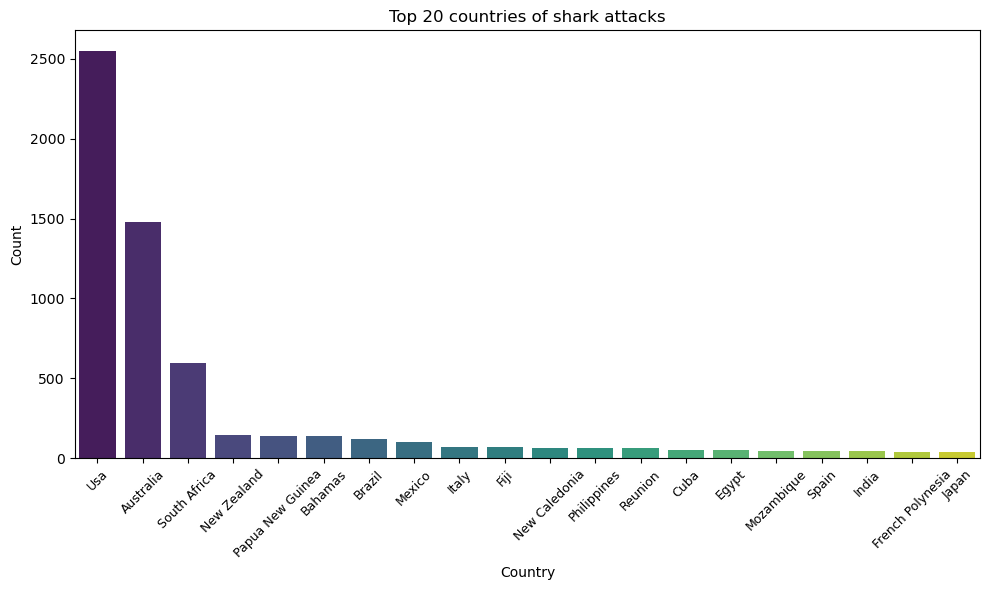

In [16]:
# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_countries.index.str.title(), y=top_20_countries.values, palette='viridis')
plt.title('Top 20 countries of shark attacks')
plt.xlabel('Country')
plt.tick_params(axis='x', labelsize=9)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Jonathan - sex wrangling

#my copy of df
jon_df = shark_df.copy()

#check unique values
unique_values_sex = jon_df['sex'].value_counts(dropna=False)
print(f"Unique values before cleaning: {unique_values_sex}")

# Remove extra spaces
jon_df['sex'] = jon_df['sex'].str.strip()

# Replace specific values
jon_df['sex'] = jon_df['sex'].replace({
    'M': 'M',  # Standard "M"
    'F': 'F',  # Standard "F"
    'N': np.nan,  # Likely an error or placeholder, so set as NaN
    'M x 2': 'M',  # Assuming this means "male," so map to "M"
    'lli': np.nan,  # Unrecognized value, replace with NaN
    '.': np.nan,  # Unrecognized value, replace with NaN
    ' M': 'M'  # Correct extra space for "M"
})

jon_df['sex']= jon_df['sex'].fillna('unknown')

#replaced NaN as unknown for now? Suggestion: change the unknown values to M or F based on the percentage of M and F we do know. 
# eg. total M is 88% of total, and F is 12%. Apply those percentages to the unknown values.

# Step 1: Calculate the counts of "M" and "F"
#total_known = jon_df['sex'].value_counts()
#m_count = total_known['M']
#f_count = total_known['F']
#total = m_count + f_count

# Step 2: Calculate the percentages of "M" and "F"
#m_percentage = m_count / total
#f_percentage = f_count / total

# Step 3: Determine the number of "Unknown" values
#unknown_count = jon_df['sex'].value_counts().get('Unknown', 0)

# Step 4: Calculate how many "Unknown" values to fill with "M" and "F"
#m_fill_count = int(m_percentage * unknown_count)
#f_fill_count = unknown_count - m_fill_count  # Remaining to ensure the total matches

# Step 5: Replace "Unknown" values with "M" and "F" based on calculated counts
# First, get the indices of the "Unknown" entries
#unknown_indices = jon_df[jon_df['sex'] == 'Unknown'].index

# Randomly sample indices for M and F replacements
#m_indices = np.random.choice(unknown_indices, size=m_fill_count, replace=False)
#f_indices = unknown_indices.difference(m_indices)

# Assign "M" to sampled indices and "F" to remaining indices
#jon_df.loc[m_indices, 'sex'] = 'M'
#jon_df.loc[f_indices, 'sex'] = 'F'

jon_df['sex']= jon_df['sex'].fillna('unknown')


unique_values_sex = jon_df['sex'].value_counts(dropna=False)
print(f"Unique values after cleaning: {unique_values_sex}")



Unique values before cleaning: sex
M        5599
F         787
NaN       579
M           2
N           2
 M          1
lli         1
M x 2       1
.           1
Name: count, dtype: int64
Unique values after cleaning: sex
M          5603
F           787
unknown     583
Name: count, dtype: int64


In [20]:
# Jonathan - age wrangling

import numpy as np

# Set Pandas option to display all rows
pd.set_option('display.max_rows', None)

# Show all unique values in the 'age' column, including NaN counts
unique_values_age = jon_df['age'].value_counts(dropna=False)
print(f"Unique values before cleaning:\n{unique_values_age}")

# Reset the display option back to default to avoid affecting other output
pd.reset_option('display.max_rows')

Unique values before cleaning:
age
NaN                        2995
16                           92
19                           90
17                           88
17                           85
18                           85
15                           84
20                           78
20                           74
18                           74
15                           72
21                           70
25                           69
22                           67
14                           63
19                           61
21                           59
16                           59
22                           59
24                           58
26                           57
24                           56
13                           55
12                           54
14                           52
25                           49
28                           48
29                           48
13                           48
23                           47
35   

In [36]:
import re

# Step 1: Handle common descriptive terms with approximate ages
def convert_descriptive_age(value):
    if pd.isnull(value):
        return np.nan
    value = str(value).strip().lower()
    if value in ["teen", "teens"]:
        return 15  # Approximate age for teenagers
    elif value == "adult":
        return 30  # General average for adult age
    elif value in ["middle age", '"middle-age"']:
        return 45  # Approximate age for middle age
    elif value == "elderly":
        return 70  # Approximate age for elderly
    elif value in ["a minor", "young"]:
        return 10  # Assume a minor is around 10 years old
    elif value == "infant" or value == "9 months" or value == "2 to 3 months":
        return 1  # Age 1 for infants
    elif "month" in value:
        return 1  # Treat other month values as infants
    return value

jon_df['age'] = jon_df['age'].apply(convert_descriptive_age)

def convert_to_first_age(value):
    if isinstance(value, str):
        # Extract first number found in the string, ignoring the rest
        numbers = re.findall(r'\d+', value)
        if numbers:
            return int(numbers[0])  # Use the first number as the age
    return value

jon_df['age'] = jon_df['age'].apply(convert_to_first_age)

def convert_half_age(value):
    if isinstance(value, str) and "½" in value:
        # Replace "½" with ".5" and convert to float
        return float(value.replace("½", ".5"))
    return value  # Return unchanged if not fractional

jon_df['age'] = jon_df['age'].apply(convert_half_age)


def convert_irregular_entries(value):
    if isinstance(value, str):
        # If the string contains no digits at all, set it to NaN
        if not any(char.isdigit() for char in value):
            return np.nan
    return value

jon_df['age'] = jon_df['age'].apply(convert_irregular_entries)

jon_df['age'] = jon_df['age'].astype('Int64')

# Replace <NA> with a specific integer value
jon_df['age'] = jon_df['age'].fillna(0)  # Replaces <NA> with 0, for the sake of easier manipulation?

# Set Pandas option to display all rows
pd.set_option('display.max_rows', None)

# Show all unique values in the 'age' column, including NaN counts
unique_values_age = jon_df['age'].value_counts(dropna=False)
print(f"Unique values after cleaning:\n{unique_values_age}")

# Reset the display option back to default to avoid affecting other output
pd.reset_option('display.max_rows')



Unique values after cleaning:
age
0     3009
17     175
15     174
20     167
18     161
19     152
16     152
21     132
22     127
25     120
14     116
24     114
13     105
30     103
26      99
23      91
28      89
12      86
29      86
27      84
32      83
35      79
10      69
40      67
38      60
31      59
34      56
33      53
36      51
50      50
43      48
42      48
37      47
11      46
9       46
41      45
39      43
45      43
52      40
46      37
8       36
49      34
47      33
48      32
44      32
7       30
55      28
51      28
60      27
57      24
58      22
54      21
6       18
59      17
53      17
61      16
56      15
62      12
70      11
69      10
63      10
64      10
68      10
65       9
5        7
66       7
1        5
3        5
73       5
71       4
77       4
75       4
67       3
74       3
4        2
2        2
78       2
82       1
72       1
86       1
84       1
87       1
81       1
Name: count, dtype: Int64


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

gender_counts = jon_df['sex'].value_counts()
print(gender_counts)

sex
M          5603
F           787
unknown     583
Name: count, dtype: int64


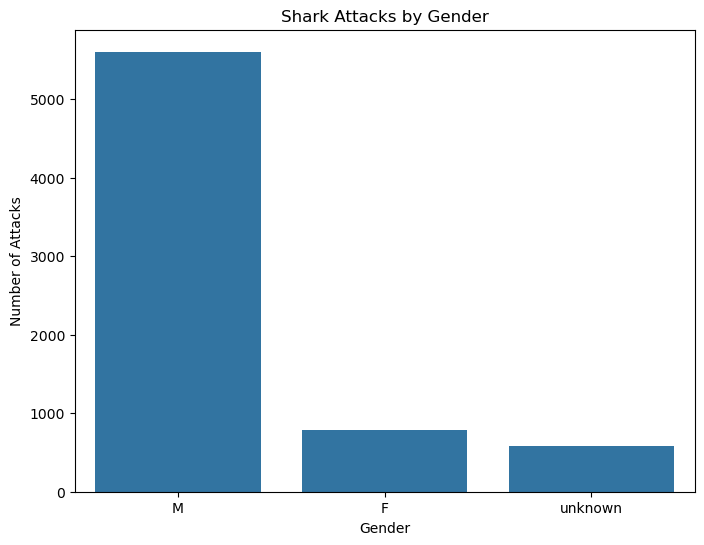

In [40]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=jon_df, order=gender_counts.index)
plt.title('Shark Attacks by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Attacks')
plt.show()

In [42]:
age_bins = [0, 17, 30, 50, 100]  # Define bins for age ranges
age_labels = ['0-17', '18-30', '31-50', '51+']
jon_df['age_group'] = pd.cut(jon_df['age'], bins=age_bins, labels=age_labels)

age_group_counts = jon_df['age_group'].value_counts().sort_index()
print(age_group_counts)

age_group
0-17     1074
18-30    1525
31-50    1000
51+       365
Name: count, dtype: int64


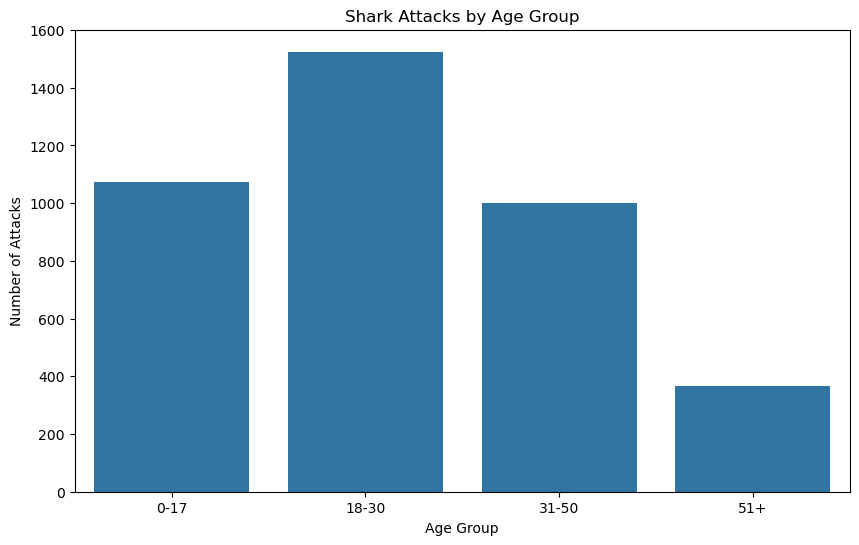

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', data=jon_df, order=age_group_counts.index)
plt.title('Shark Attacks by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Attacks')
plt.show()

In [ ]:
# Bru - fatality wrangling

#copy df for safety reasons
bru_df = shark_df.copy()

# rename column
bru_df.rename(columns={'unnamed:_11': 'fatal'}, inplace=True)

# check unique values
unique_values_fatal = bru_df['fatal'].unique()
print(f"Unique values before cleaning: {unique_values_fatal}")

# replace values
bru_df['fatal'] = bru_df['fatal'].replace({'N':'no','Y':'yes','n':'no','Y x 2':'yes',' N':'no','N ':'no','y':'yes','UNKNOWN':'unknown'})

# remove rows with specific values
rows_to_remove = ['Nq', 'M', 'F', 2017]
bru_df = bru_df[~bru_df['fatal'].isin(rows_to_remove)]

#drop rows with NaN values
bru_df = bru_df.dropna(subset=['fatal'])

# check again
unique_values_fatal = bru_df['fatal'].unique()
print(f"Unique values after cleaning: {unique_values_fatal}")

# print(bru_df.describe())
print(bru_df.groupby('fatal').count())

In [ ]:
# Bru - activity wrangling
from collections import Counter
import re

# check unique values
unique_values_activity = bru_df['activity'].unique()
# print(unique_values_activity)

# convert all values to a common case
bru_df['activity'] = bru_df['activity'].str.strip().str.lower().str.replace(r"[\"']", '', regex=True)

'''
The word_count() function uses collections and re to concatenate all the values in the column to a single string.
Then it will split the combined string into individual words.
Using Counters, it will return the frequency of each word.
It will also store the top 10 most common words in a list
'''

most_common_words = []

def word_count():
    bru_df['activity'] = bru_df['activity'].fillna('').astype(str) # replace NaN values with an empty string and convert all to string
    all_text = ' '.join(bru_df['activity']) # combine all values into a single string
    words = re.findall(r'\w+', all_text.lower()) # split into words (regex to handle punctuation)
    word_counts = Counter(words) # count word frequency
    most_common_words = [word for word, count in word_counts.most_common(50) if len(word) >= 5]
    return most_common_words
    return word_count

word_count()
most_common_words = word_count()

#print("Most common words")
#print(most_common_words)

print('Top values before replacement function\n', bru_df['activity'].value_counts().head(10))
#manually entered seoelcted values
selected_values_to_replace = ['surfing', 'diving', 'fishing', 'swimming', 'wading', 'bathing', 'snorkeling', 'kayaking', 'body boarding', 'scuba diving']


def replace_values():
    for word_to_replace in selected_values_to_replace:
        bru_df.loc[bru_df['activity'].str.contains(word_to_replace, case=False, na=False), 'activity'] = word_to_replace

    return bru_df

updated_bru_df = replace_values()

print('\nTop values after replacement:\n', updated_bru_df['activity'].value_counts().head(10))

# print("Word count:")
# print(word_counts_df)

In [ ]:
# playing with visual representation
import matplotlib.pyplot as plt
import seaborn as sns

# Count top 10 values in the 'activity' column
top_values = updated_bru_df['activity'].str.capitalize().value_counts().head(10)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')
plt.title('Top 10 activities that may result in shark attacks')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Columns we need in the project
- Years
- date (months?)
- activity (can we stand on a beach?)
- country/state/location -> do we need all? let's start with country + location and see how messy it gets from then on?
- age - hospital costs might change
- sex
- unnamed 11 (fatal or not) yes for fatal
- injury (how does that combine with activity type?)
- Jonathan adds column with organs lost

### Formula
probably looks like : who are you, where are you, what are you going to do and when? -> probability calculated through that (will it be fatal or not), and then the result can be checked into the three insurance categories

- location is going to be an important parameter here (another correlation to definitely check, big influential factor?)

- !POINT SYSTEM!

- add point system for column unique values (genius)

### Other parameters to take into account:
- comparison between years to calculate potential drama in upcoming years
- calculate probability based on different parameters
- we're g etting creepy

## Next steps
1. Select columns we will use
2. Inspect column data, see where we have null or empty values
3. Decide what to do with the above
4. 'homogenize' column values
5. Figure out calculations for probability. 